# Climate change over the years

## Install dependencies

In [ ]:
%bash
pip install fbprophet
pip install plotly
pip install cufflinks

## Here reset the session

In [1]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Facebook's Prophet forecasting library
from fbprophet import Prophet

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Pulling the data

In [2]:
# Read in the raw temperature and emissions datasets (they are in CSV format) 
raw_temperature = pd.read_csv('../raw_data/GLB.Ts+dSST.csv', skiprows=1)
raw_emissions = pd.read_csv('../raw_data/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380.csv', skiprows=3)

In [3]:
# Investigate how the raw data looks
raw_temperature.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.29,-0.18,-.11,-.19,-.11,-.23,-.21,-.09,-.16,-.23,-.20,-.22,-.18,***,***,-.14,-.18,-.19
1,1881,-0.15,-0.17,.04,.04,.02,-.20,-.06,-.02,-.13,-.20,-.21,-.10,-.09,-.10,-.18,.04,-.09,-.18
2,1882,0.15,0.15,.04,-.18,-.15,-.25,-.20,-.05,-.10,-.24,-.15,-.24,-.10,-.09,.07,-.10,-.17,-.16
3,1883,-0.31,-0.38,-.12,-.16,-.19,-.12,-.08,-.15,-.20,-.14,-.22,-.15,-.19,-.19,-.31,-.16,-.11,-.19
4,1884,-0.15,-0.08,-.37,-.42,-.36,-.40,-.34,-.26,-.27,-.24,-.29,-.28,-.29,-.28,-.13,-.38,-.33,-.27


In [4]:
raw_emissions.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,24.670529,24.505835,13.155542,8.351294,8.408363,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.046060,0.053604,0.073765,0.074233,0.086292,0.101467,...,0.293837,0.412017,0.350371,0.315602,0.299445,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.097472,0.079038,0.201289,0.192535,0.201003,0.191528,...,1.243406,1.252789,1.330843,1.254617,1.291328,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1.258195,1.374186,1.439956,1.181681,1.111742,1.166099,...,1.578574,1.803715,1.692908,1.749211,1.978763,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,6.122595,5.867130,5.916597,5.900753,5.832170,NaN,NaN,NaN,NaN,NaN


# Wrangling Time Series Data

## Wrangling Temperature

In [5]:
# Create new dataframe with an index for each month
# First create the date range
date_rng = pd.date_range(start='1/1/1880', end='1/03/2019', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# Next create the empty DataFrame, which we will populate using the actual data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Anomaly_deg_C'] = None

# Set the index of the DataFrame to the date column (DateTime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,None
1880-02-29,None
1880-03-31,None
1880-04-30,None
1880-05-31,None


In [6]:
# We only want the monthly data, lets only select that and leave out the seasonal columns 
raw_temperature = raw_temperature.iloc[:,:13]
raw_temperature.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1880,-0.29,-0.18,-.11,-.19,-.11,-.23,-.21,-.09,-.16,-.23,-.20,-.22
1,1881,-0.15,-0.17,.04,.04,.02,-.20,-.06,-.02,-.13,-.20,-.21,-.10
2,1882,0.15,0.15,.04,-.18,-.15,-.25,-.20,-.05,-.10,-.24,-.15,-.24
3,1883,-0.31,-0.38,-.12,-.16,-.19,-.12,-.08,-.15,-.20,-.14,-.22,-.15
4,1884,-0.15,-0.08,-.37,-.42,-.36,-.40,-.34,-.26,-.27,-.24,-.29,-.28


In [7]:
# Import relevant libraries
import calendar
from datetime import datetime

# Function definition
def populate_df_with_anomolies_from_row(row):
    year = row['Year']
    # Anomaly values (they seem to be a mixture of strings and floats)
    monthly_anomolies = row.iloc[1:]
    # Abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # Get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
       
        date_index = datetime.strptime("{} {} {}".format(year, month, last_day), '%Y %b %d')
        # Populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# Apply function to each row of raw data 
_ = raw_temperature.apply(lambda row: populate_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-.11
1880-04-30,-.19
1880-05-31,-.11


In [8]:
# Import Numpy, as library meant for large arrays - we will use it that we 
import numpy as np

# Define function to convert values to floats, and return a 'NaN = Not a Number' if this is not possible
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Apply above function to all anomaly values in DataFrame
t['Avg_Anomaly_deg_C'] = t['Avg_Anomaly_deg_C'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' to take care of NaN values
t.fillna(method='ffill', inplace=True)

# Show the first few elements of our newly cleaned DataFrame
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-0.11
1880-04-30,-0.19
1880-05-31,-0.11


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



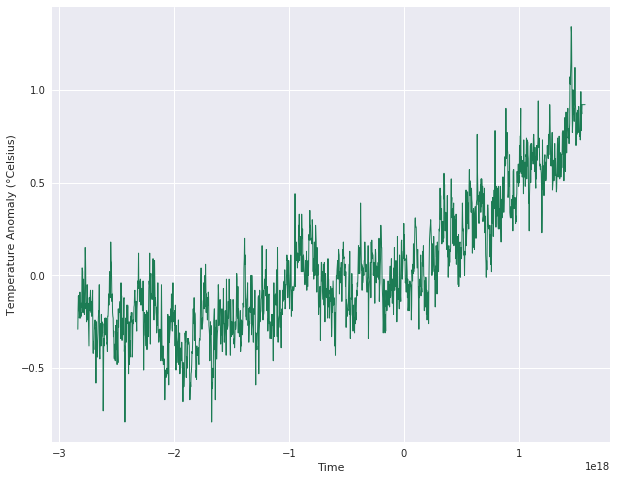

In [9]:
# Plot the data - quick and easy - using matplotlib, we will draw prettier graphs later

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline

# Create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t, color='#1C7C54', linewidth=1.0)

In [10]:
# The data can be resampled to a different frequency, 
# lets resample it to years (end-of-year):
t.resample('A').mean().head()

,Avg_Anomaly_deg_C
date,
1880-12-31,-0.185000
1881-12-31,-0.095000
1882-12-31,-0.101667
1883-12-31,-0.185000
1884-12-31,-0.288333


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



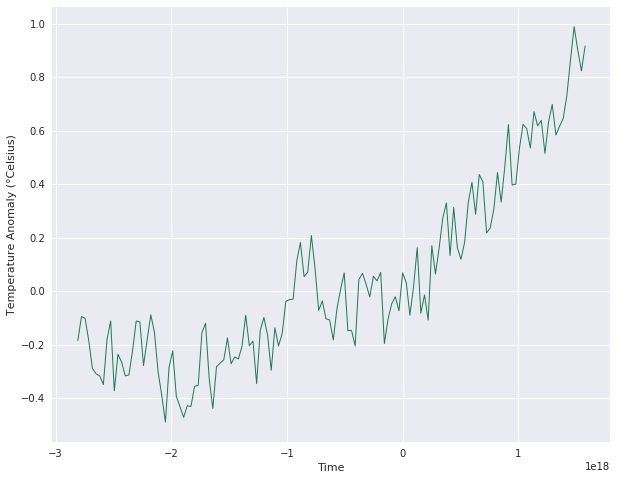

In [11]:
# Now lets visualize our resampled DataFrame

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline
# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='#1C7C54', linewidth=1.0)

## Wrangling Emissions

In [13]:
# Define function to pull value from raw data, using DateIndex from new DataFrame row
def populate_df(row):
    index = str(row['date'].year)
    value = raw_e_world.loc[index]
    return value
  
# Select just the co2 emissions for the 'world', and the columns for the years 1960-2018 
raw_e_world = raw_emissions[raw_emissions['Country Name']=='World'].loc[:,'1960':'2018']

# 'Traspose' the resulting slice, making the columns become rows and vice versa
raw_e_world = raw_e_world.T
raw_e_world.columns = ['value']

# Create a new DataFrame with a daterange the same the range for.. 
# the Temperature data (after resampling to years)
date_rng = pd.date_range(start='31/12/1960', end='31/12/2018', freq='y')
e = pd.DataFrame(date_rng, columns=['date'])

# Populate the new DataFrame using the values from the raw data slice
v = e.apply(lambda row: populate_df(row), axis=1)
e['Global CO2 Emissions per Capita'] = v
e.set_index('date', inplace=True)
e.head()

,Global CO2 Emissions per Capita
date,
1960-12-31,3.099013
1961-12-31,3.069727
1962-12-31,3.140511
1963-12-31,3.244499
1964-12-31,3.360596


In [14]:
# Illustrate how the above DataFrame can be filtered for values after 2011
e[e.index.year>2011]

,Global CO2 Emissions per Capita
date,
2012-12-31,4.996211
2013-12-31,4.987739
2014-12-31,4.969974
2015-12-31,NaN
2016-12-31,NaN
2017-12-31,NaN
2018-12-31,NaN


In [15]:
# Deal with the NaNs by 'forward filling'
e.fillna(method='ffill', inplace=True)

In [16]:
# Check that there are no longer NaNs at the end 
e[e.index.year>2011]

,Global CO2 Emissions per Capita
date,
2012-12-31,4.996211
2013-12-31,4.987739
2014-12-31,4.969974
2015-12-31,4.969974
2016-12-31,4.969974
2017-12-31,4.969974
2018-12-31,4.969974


In [17]:
e['1984-01-04':'1990-01-06']

,Global CO2 Emissions per Capita
date,
1984-12-31,4.019671
1985-12-31,4.068895
1986-12-31,4.118996
1987-12-31,4.146842
1988-12-31,4.221216
1989-12-31,4.238247


In [19]:
# Define function to pull value from raw data, using DateIndex from new DataFrame row
def populate_df(row):
    index = str(row['date'].year)
    value = raw_e_chile.loc[index]
    return value
  
# Select just the co2 emissions for the 'world', and the columns for the years 1960-2018 
raw_e_chile = raw_emissions[raw_emissions['Country Name']=='Chile'].loc[:,'1960':'2018']

# 'Traspose' the resulting slice, making the columns become rows and vice versa
raw_e_chile = raw_e_chile.T
raw_e_chile.columns = ['value']

# Create a new DataFrame with a daterange the same the range for.. 
# the Temperature data (after resampling to years)
date_rng = pd.date_range(start='31/12/1960', end='31/12/2018', freq='y')
e = pd.DataFrame(date_rng, columns=['date'])

# Populate the new DataFrame using the values from the raw data slice
v = e.apply(lambda row: populate_df(row), axis=1)
e['Global CO2 Emissions per Capita'] = v
e.set_index('date', inplace=True)
e.head()

,Global CO2 Emissions per Capita
date,
1960-12-31,1.748289
1961-12-31,1.834393
1962-12-31,2.073250
1963-12-31,2.104406
1964-12-31,2.078630


# Final DataFrames

In [ ]:
# Temperature anomalies
t.head()

In [ ]:
# Temperature anomalies resampled to end-of-year
t.resample('A').mean().head()

In [ ]:
# CO2 emissions
e.head()

# Visualizing Time Series Data

## Plotting Temperature with Matplotlib

In [ ]:
# import Matplotlib
import matplotlib.pyplot as plt
# Allow for graphs to be displayed in Jupyter notebook
%matplotlib inline

# Resample or temperature data to years (end-of-year)
t_resampled = t.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot temperature data with specific colour and line thickness
ax.plot(t_resampled, color='#1C7C54', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Temperature Anomaly (deg. Celsius)',
       title='Global Temperature Anomalies')

# Enable grid
ax.grid()


## Plotting Emissions with Matplotlib

In [ ]:
# import Matplotlib
import matplotlib.pyplot as plt
# Allow for graphs to be displayed in Jupyter notebook
%matplotlib inline

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(e, color='#3393FF', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Emissions (Metric Tons per Capita)',
       title='Global CO2 Emission over Time')

# Enable grid
ax.grid()

## Plotting Temperature with Plotly

In [ ]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [ ]:
t.resample('A').mean().iplot(kind='line', xTitle='Time (years)', color='#1C7C54',
                  yTitle='Temperature Anomaly (deg. Celsius)', title='Global Temperature Anomalies')

## Plotting Emissions with Plotly

In [ ]:
e.iplot(kind='line', xTitle='Time (years)', color='#3393FF',
                  yTitle='Emissions (Metric Tons per Capita)', title='Global CO2 Emission over Time')

# Timeseries Correlation

## Granger Causality

## Dynamic Time Warping

In [ ]:
# The above will be available in another post soon! The post will also use these same two time series.

# Time Series Modelling and Forecasting

## Facebook Prophet

In [ ]:
t_prophet = pd.DataFrame()
t_prophet['ds'] = t.index
t_prophet['y'] = t['Avg_Anomaly_deg_C'].values

In [ ]:
m = Prophet()
m.fit(t_prophet)

In [ ]:
# Make future dataframes
future = m.make_future_dataframe(freq='m', periods=100*12)
forecast = m.predict(future)

In [ ]:
m.plot(forecast);

In [ ]:
m.plot_components(forecast);

## Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
# This will also be available in a future post

# THE END